Research Track 2: Jupyter Notebook for third RT1 assignment

In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from random import randint


In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Button,Layout,ButtonStyle, HBox

In [3]:
import rospy
from rt1_assignment3.srv import BehaviorMode, Goal
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
from sensor_msgs.msg import LaserScan
from std_msgs.msg import Int32

In [4]:
b1 = Button(description='Automatic',
        layout=Layout(width='auto', align="center", grid_area='b1'),
        style=ButtonStyle(button_color='lightblue'))
b2 = Button(description='Full manual',
        layout=Layout(width='auto', grid_area='b2'),
        style=ButtonStyle(button_color='moccasin'))
b3 = Button(description='Assisted manual',
        layout=Layout(width='auto', grid_area='b3'),
        style=ButtonStyle(button_color='salmon'))

b4 = widgets.FloatText(
    value=7.5,
    description='Goal x:',
    disabled=False
)
b5 = widgets.FloatText(
    value = 0,
    description = 'Goal y:',
    disabled=False
)
            

In [5]:
def change_mode(x):
    rospy.wait_for_service('/switch_mode')
    try:
        client = rospy.ServiceProxy('/switch_mode', BehaviorMode)
        result = client(x)
        if result:
            msg="mode %d selected" %x
        else:
            msg="no change"
    except rospy.ServiceException as e:
        msg="service /switch_mode has failed"
    return(msg)
        
def send_goal(b):
    msg = ''
    with output:
        clear_output(wait=True)
        rospy.wait_for_service('/set_goal')
        try:
            client = rospy.ServiceProxy('/set_goal', Goal)
            result = client(b4.value, b5.value)
            if result:
                msg="goal set"
            else:
                msg="goal not set"
        except rospy.ServiceException as e:
            msg="service /set_goal has failed"
    print(msg)


In [13]:
class Visualiser:
    def __init__(self, limit_on_x, fig_title):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
        self.x_limits=limit_on_x
        plt.grid()
        self.ax.set_title(fig_title)
        
    def plot_init(self):
        self.ax.set_xlim(-self.x_limits, self.x_limits)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def scan_callback(self, msg):
        self.x_data = msg.ranges
        self.y_data = msg.intensities        
   
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    
class Success:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.y_data = [0.05,0.05] 
        self.labels = ['reached', 'abandonned'] 
        self.bar = self.ax.bar(self.labels, self.y_data, color = 'r', width = 0.4)
        self.ax.set_ylim(top = 13)
        self.ax.set_title('Automatic : number of goals sent and result')
    
     
    
    def feedback_callback(self, msg):
        if msg.data == 1:
            self.y_data[0]+=1
        else :
            self.y_data[1]+=1
            
    def animate(self, frame):
        index = self.y_data[frame]
        self.bar[frame].set_height(index)


In [7]:
#handle changes, the observe method of the widget can be used to register a callback.
def on_button_clicked1(b):
    ret_val = ''    
    #clear_output(wait=True)
    with output:        
        ret_val=change_mode(1)
    print(ret_val)
        
def on_button_clicked2(b):
    ret_val = ''
    #clear_output(wait=True)
    with output:
        ret_val=change_mode(2)    
    print(ret_val)
        
def on_button_clicked3(b):
    ret_val = ''    
    #clear_output(wait=True)
    with output:
        ret_val=change_mode(3)
    print(ret_val)
        
b1.on_click(on_button_clicked1)
b2.on_click(on_button_clicked2)
b3.on_click(on_button_clicked3)
      
output = widgets.Output()
display(HBox([b1,b2,b3]), output)

mode 1 selected


In [8]:
b6 = Button(description='send goal',
        layout=Layout(width='auto', grid_area='b6'),
        style=ButtonStyle(button_color='lightblue'))

b6.on_click(send_goal)      
output = widgets.Output()
display(HBox([b4,b5,b6]))

goal set
goal set
goal set


Position of the robot


<IPython.core.display.Javascript object>


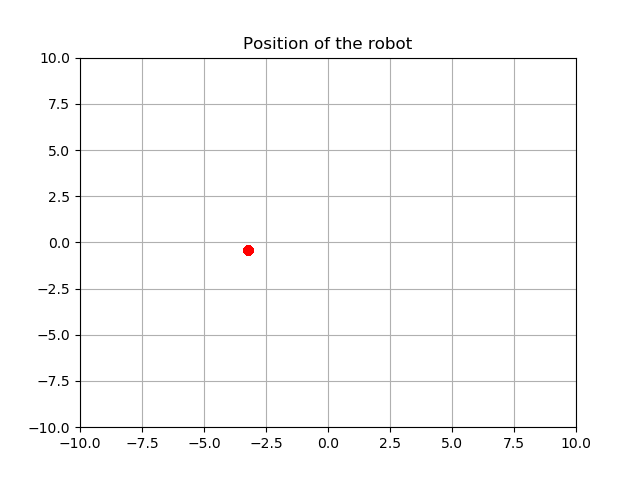

In [14]:

rospy.init_node('odom_visualizer_node')
vis_odom = Visualiser(10, 'Position of the robot')
sub_odom = rospy.Subscriber('/odom', Odometry, vis_odom.odom_callback)
ani1 = FuncAnimation(vis_odom.fig, vis_odom.update_plot, init_func=vis_odom.plot_init)
plt.show(block=True)


<IPython.core.display.Javascript object>


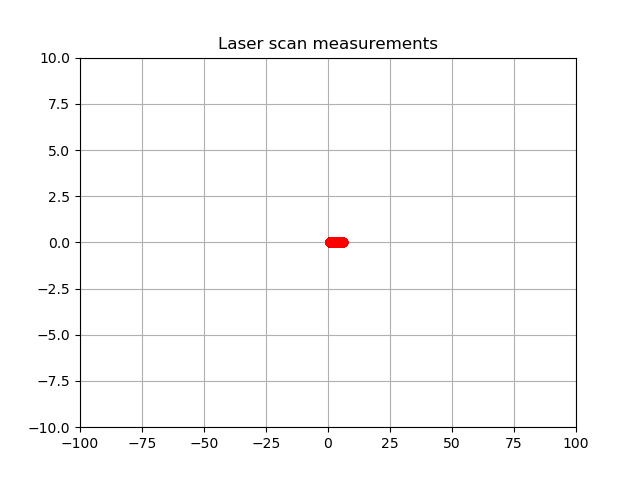

In [15]:

vis_scan = Visualiser(100, 'Laser scan measurements')
sub_scan = rospy.Subscriber('/scan', LaserScan, vis_scan.scan_callback)
ani2 = FuncAnimation(vis_scan.fig, vis_scan.update_plot, init_func=vis_scan.plot_init)
plt.show(block=True)

<IPython.core.display.Javascript object>


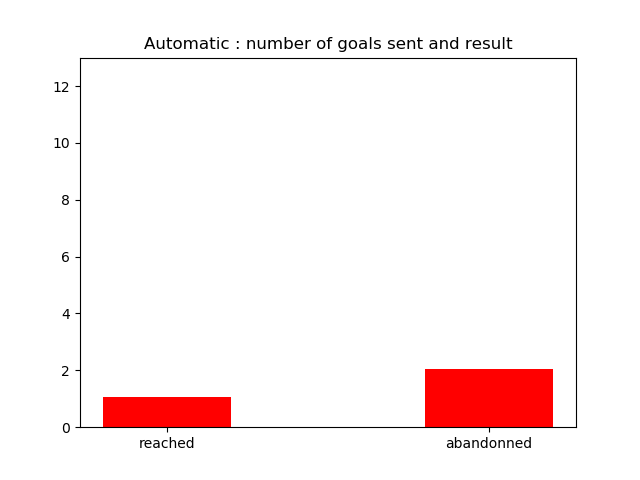

In [11]:
success= Success()
sub_success = rospy.Subscriber('/goal_reached', Int32, success.feedback_callback)
ani3 = FuncAnimation(success.fig, success.animate, frames=2)
plt.show(block=True)
       